### Aprendizaje Supervisado

In [1]:
#Importamos librerías con las que se van a trabajar
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import sklearn

In [2]:
personas=pd.read_csv('../datos/personas_l.csv') 

In [3]:
viajes=pd.read_csv('../datos/viajes_l.csv')

C:\Users\USUARIO\AppData\Local\Temp\ipykernel_12484\1770654665.py:1: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  viajes=pd.read_csv('../datos/viajes_l.csv')


### 1) Clasificación

In [4]:
# Función auxiliar Feature Importance
def feature_importance(model, feature_list):
    """
    Function that gets and plots the feature importance
    for the given model
    :param model: the model to evaluaate
    :param feature_list: a list of features contained in the model

    :returns a plot with feature importance
    """
    importances = list(model.feature_importances_)
    feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
    feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
    [print('Variable: {} Importance: {}'.format(*pair)) for pair in feature_importances];
    colors = plt.cm.rainbow(np.linspace(0, 1, len(feature_list))) 
    characteristics = [x[0] for x in feature_importances]
    importances_plot = [x[1] for x in feature_importances]
    plt.bar(characteristics, importances_plot, color=colors)
    plt.xticks(list(range(len(characteristics))), characteristics, rotation = 90)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['bottom'].set_visible(False)
    plt.gca().spines['left'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gcf().subplots_adjust(bottom=0.3);

### Procesamiento y transformación de datos

Transformamos la variable `motivo` utilizando el metodo apply: Assignamos 0 a motivos de viaje relacionados al trabajo o estudio, y 1 a otros motivos.

In [5]:
categorias_a_asignar_0 = [2,3,4,5,14]

In [6]:
viajes['motivo'] = viajes['motivo'].apply(lambda x: 0 if x in categorias_a_asignar_0 else 1)

In [7]:
viajes.head()

,Unnamed: 0,id_hogar,id_persona,id_viaje,actividad_en_el_origen,actividad_en_el_destino,BH_NBH,motivo,veces_por_semana_viaja,tarifa_combinada,...,hora_final,duracion_minutos,modo_des,PONDERA,cantidad_etapas,tipo_viaje,menos_2_cuadras,Inluye_bici,viaja_rmba,distancia_viaje_km
0,0,1,2,1,1,2,BH,0,5,0,...,10.666667,40.0,5,503,1,PBA,0,no,1,0.011419
1,1,1,2,2,2,1,BH,0,5,0,...,17.666667,40.0,5,503,1,PBA,0,no,1,0.011419
2,2,2,1,1,1,3,BH,0,88,0,...,10.250000,60.0,4,464,1,PBA,0,no,1,0.030933
3,3,2,1,2,3,1,BH,0,88,0,...,13.000000,60.0,4,464,1,PBA,0,no,1,0.030933
4,4,3,1,1,1,7,BH,1,88,0,...,12.000000,180.0,3,462,1,PBA,0,no,1,0.032295


Para las variables `partido_origen_viaje`, `tipo_viaje`y `partido-origen_destino`, utilizaremos `LabelEncoder`, ya que si bien no tienen un orden inherente utilizando `.get_dummies` utilizarimos demasiado espacio en la memoria.

In [8]:
from sklearn.preprocessing import LabelEncoder

In [9]:
origen_encoder = LabelEncoder()

In [10]:
viajes.loc[:, 'partido_origen_viaje'] = origen_encoder.fit_transform(viajes['partido_origen_viaje'])

C:\Users\USUARIO\AppData\Local\Temp\ipykernel_12484\3173553331.py:1: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  viajes.loc[:, 'partido_origen_viaje'] = origen_encoder.fit_transform(viajes['partido_origen_viaje'])


In [11]:
destino_encoder = LabelEncoder()

In [12]:
viajes.loc[:, 'partido_destino_viaje'] = destino_encoder.fit_transform(viajes['partido_destino_viaje'])

C:\Users\USUARIO\AppData\Local\Temp\ipykernel_12484\3893151721.py:1: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  viajes.loc[:, 'partido_destino_viaje'] = destino_encoder.fit_transform(viajes['partido_destino_viaje'])


In [13]:
tpoviaj_encoder = LabelEncoder()

In [14]:
viajes.loc[:, 'tipo_viaje'] = tpoviaj_encoder.fit_transform(viajes['tipo_viaje'])

C:\Users\USUARIO\AppData\Local\Temp\ipykernel_12484\1144690609.py:1: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  viajes.loc[:, 'tipo_viaje'] = tpoviaj_encoder.fit_transform(viajes['tipo_viaje'])


A continuación se unirán las Bases de Datos "Personas" con "Viajes", de manera que el modelo pueda considerar algunas características de las personas que viajan. Dado que los mismos son muy grandes y no hay espacio suficiente, eliminaremos algunas columnas que no se incluirán en el modelo.

In [15]:
personas.drop(labels=['partido', 'nombre_partido', 'relacion_con_jefe_de_hogar', 'dificultad', 'nivel_cursando', 'Trabaja_Si_No (0=SD)', 'situacion_laboral', 'por_que_no_trabajo', 'por_que_no_trabajo_otro','por_que_no_tiene_empleo_remunerado','por_que_no_tiene_empleo_otro', 'trabaja_como', 'forma_aporte', 'ambito_laboral','ambito_laboral_otro', 'cobertura', 'lugar_atencion', 'lugar_atencion', 'viajo_ayer','motivos_no_viajo_ayer','PONDERA'], axis=1, inplace=True)


In [16]:
viajes.columns

Index(['Unnamed: 0', 'id_hogar', 'id_persona', 'id_viaje',
       'actividad_en_el_origen', 'actividad_en_el_destino', 'BH_NBH', 'motivo',
       'veces_por_semana_viaja', 'tarifa_combinada', 'jur_origen',
       'jur_destino', 'partido_origen_viaje', 'partido_destino_viaje',
       'cod_partido_origen', 'cod_partido_destino', 'hora_inicio',
       'hora_final', 'duracion_minutos', 'modo_des', 'PONDERA',
       'cantidad_etapas', 'tipo_viaje', 'menos_2_cuadras', 'Inluye_bici',
       'viaja_rmba', 'distancia_viaje_km'],
      dtype='object')

In [17]:
viajes.drop(labels=['id_viaje', 'actividad_en_el_origen', 'actividad_en_el_destino', 'BH_NBH','tarifa_combinada', 'jur_origen', 'jur_destino','cod_partido_origen', 'cod_partido_destino',
       'hora_inicio', 'hora_final', 'PONDERA','cantidad_etapas', 'menos_2_cuadras', 'Inluye_bici',
       'viaja_rmba'], axis=1, inplace=True )

In [18]:
mov_mot = pd.merge(viajes, personas, on=['id_persona', 'id_hogar'], how='inner')

In [19]:
mov_mot.isna().sum()

Unnamed: 0_x              0
id_hogar                  0
id_persona                0
motivo                    0
veces_por_semana_viaja    0
partido_origen_viaje      0
partido_destino_viaje     0
duracion_minutos          0
modo_des                  0
tipo_viaje                0
distancia_viaje_km        0
Unnamed: 0_y              0
edad                      0
sexo                      0
cursa_actualmente         0
ambito_cursando           0
nivel_aprobado            0
licencia_de_conducir      0
dtype: int64

In [20]:
mov_mot[mov_mot.isna().any(axis=1)]

,Unnamed: 0_x,id_hogar,id_persona,motivo,veces_por_semana_viaja,partido_origen_viaje,partido_destino_viaje,duracion_minutos,modo_des,tipo_viaje,distancia_viaje_km,Unnamed: 0_y,edad,sexo,cursa_actualmente,ambito_cursando,nivel_aprobado,licencia_de_conducir


#### Selección de Target (y) y Variables (X)

Determinamos que la variable a predecir debe estar balanceada. En este caso se ha decidido precedir si una persona viajará por motivos de trabajo o estudio, u otros motivos. (0  motivos de viaje relacionados al trabajo o estudio, y 1 a otros motivos)

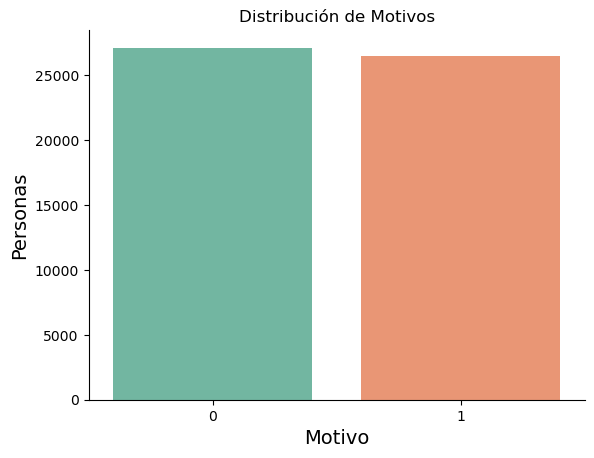

In [21]:
sns.countplot(x=mov_mot['motivo'], palette='Set2')
plt.xlabel('Motivo', size=14)
plt.ylabel('Personas', size=14)
plt.title('Distribución de Motivos')
sns.despine()

In [22]:
# Eliminamos aquellas variables que no queremos incluir en el modelo y las guardamos en x.
x = mov_mot.drop(['id_persona', 'id_hogar', 'motivo'], axis=1)

In [23]:
x.shape

(53614, 15)

In [24]:
lista_atributos = x.columns

In [25]:
lista_atributos

Index(['Unnamed: 0_x', 'veces_por_semana_viaja', 'partido_origen_viaje',
       'partido_destino_viaje', 'duracion_minutos', 'modo_des', 'tipo_viaje',
       'distancia_viaje_km', 'Unnamed: 0_y', 'edad', 'sexo',
       'cursa_actualmente', 'ambito_cursando', 'nivel_aprobado',
       'licencia_de_conducir'],
      dtype='object')

In [26]:
# Ahora seleccionamos las etiquetas y las guardamos en y.
y = mov_mot['motivo']

In [27]:
x, y = np.array(x), np.array(y)

#### Separando Train / Test

Ahora tenemos que separar el dataset en conjuntos de entrenamiento (X_train, y_train) y de testeo (X_test, y_test) usando la función train_test_split de scikit-learn.

In [28]:
from sklearn.model_selection import train_test_split

In [29]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2,
                                                    random_state=70)

In [30]:
X_train.shape

(42891, 15)

In [31]:
X_test.shape

(10723, 15)

### Modelos

In [32]:
from sklearn.neighbors import KNeighborsClassifier

In [33]:
from sklearn.ensemble import RandomForestClassifier

In [34]:
from sklearn.model_selection import GridSearchCV

In [35]:
# Métricas
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    precision_score,
    recall_score,
    f1_score
)

#### Clasificador KNN

Optimizaremos los parámetros del clasificador kNN y empezamos encontrando el mejor K.

In [36]:
ACC_train = []
ACC_test = []

vecinos = [1, 3, 5, 10, 15, 20, 27, 50]
for n in vecinos:
    
    clf = KNeighborsClassifier(n_neighbors=n)
    
    clf.fit(X_train, y_train)
    y_train_pred = clf.predict(X_train)
    
    train_acc = accuracy_score(y_train, y_train_pred)
    ACC_train.append(train_acc)
    
    y_test_pred = clf.predict(X_test)
    test_acc = accuracy_score(y_test, y_test_pred)
    ACC_test.append(test_acc)

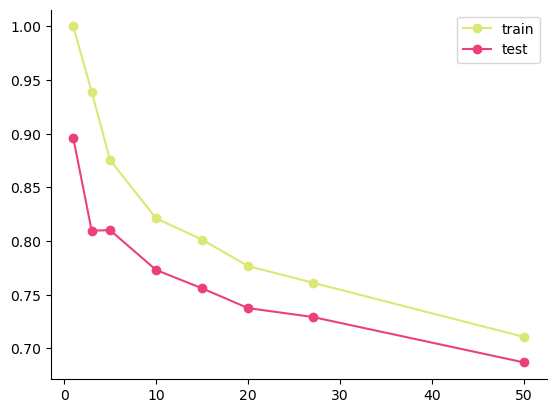

In [37]:
plt.plot(vecinos,ACC_train,'o-',label='train', color='#DCE775')
plt.plot(vecinos,ACC_test,'o-',label='test', color='#EC407A')
plt.legend()
sns.despine();

Y ahora hacemos una búsqueda con GridSearchCV para obtener los hiperparámetros óptimos utilizando además validación cruzada.

In [38]:
# Valores para los parámetros a optimizar
param_grid_vec = {
    'n_neighbors': [3, 5, 10,15,16, 25, 26],
    'weights': ['uniform','distance'],
    'metric': ['euclidean', 'manhattan'],
}

In [39]:
knn_search = KNeighborsClassifier()

In [40]:
vecinos_search = GridSearchCV(estimator=knn_search, param_grid=param_grid_vec,
                         cv=3, verbose=2, n_jobs=-1)

In [41]:
vecinos_search.fit(X_train, y_train)

Fitting 3 folds for each of 28 candidates, totalling 84 fits


GridSearchCV(cv=3, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'metric': ['euclidean', 'manhattan'],
                         'n_neighbors': [3, 5, 10, 15, 16, 25, 26],
                         'weights': ['uniform', 'distance']},
             verbose=2)

In [42]:
# Mejores hiperparámetros
vecinos_search.best_params_

{'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}

Ahora entrenemos el Modelo Final.

In [43]:
knn_best = KNeighborsClassifier(metric='manhattan', n_neighbors=10, weights='distance')

In [44]:
knn_best.fit(X_train, y_train)

KNeighborsClassifier(metric='manhattan', n_neighbors=10, weights='distance')

In [45]:
new_predictions = knn_best.predict(X_test)

**Métricas**

Matriz de confusión:

True Positive (TP)  |  False Negative (FN)   
= = = = = = = = = = = = = = = = = = = = =       
False positive (FP) | True Negative (TN)  


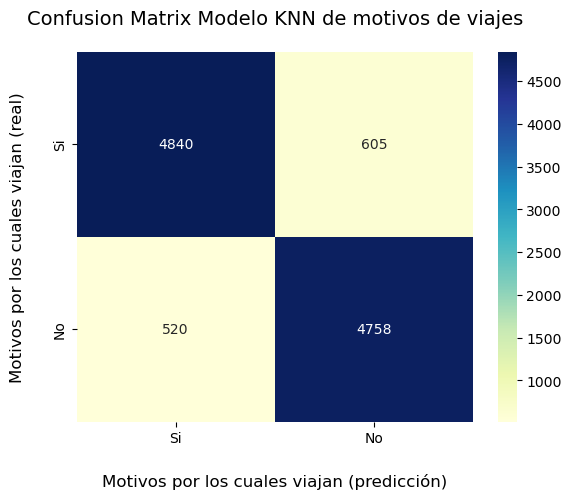

In [46]:
plt.figure()
random_confusion = confusion_matrix(y_test, new_predictions)
ax=sns.heatmap(random_confusion, cmap="YlGnBu",annot=True,fmt='d');
ax.set_xlabel("Motivos por los cuales viajan (predicción)", fontsize=12, labelpad=20)
ax.xaxis.set_ticklabels(['Si', 'No'])
ax.set_ylabel("Motivos por los cuales viajan (real)", fontsize=12, labelpad=20)
ax.yaxis.set_ticklabels(['Si', 'No'])
ax.set_title("Confusion Matrix Modelo KNN de Motivos de Viajes", fontsize=14, pad=20)
plt.show()

In [47]:
print(f"Accuracy: {accuracy_score(y_test, new_predictions)*100 :.2f}%")
print(f"Precision: {precision_score(y_test, new_predictions)*100 :.2f}%")
print(f"Recall: {recall_score(y_test, new_predictions)*100 :.2f}%")
print(f"F1 score: {f1_score(y_test, new_predictions)*100 :.2f}%")

Accuracy: 89.51%
Precision: 88.72%
Recall: 90.15%
F1 score: 89.43%


#### Clasificador RandomForest

In [48]:
# Valores para los parámetros a optimizar
param_grid_vec_random = {
    'max_features': ['auto', 'sqrt', 'log2', None],
    'max_depth': [2, 3, 4, 8, 10],
    'criterion': ['gini', 'entropy'],
    'bootstrap': [True, False],
    'n_estimators': [10, 15, 20, 30, 50, 100]

}

In [49]:
random_forest = RandomForestClassifier()

In [50]:
rf_search = GridSearchCV(estimator=random_forest, param_grid=param_grid_vec_random,
                         cv=3, verbose=2, n_jobs=-1)

In [ ]:
rf_search.fit(X_train, y_train)

Fitting 3 folds for each of 480 candidates, totalling 1440 fits


WARNING:
PARA ANALIZAR EL RANDOM FOREST
El error que estás viendo se relaciona con los parámetros del modelo `RandomForestClassifier` en una búsqueda de hiperparámetros utilizando `GridSearchCV`. El mensaje de error específicamente menciona el parámetro `max_features`, que debe ser configurado correctamente para que la búsqueda de hiperparámetros funcione sin problemas.

El error dice:

```
sklearn.utils._param_validation.InvalidParameterError: The 'max_features' parameter of RandomForestClassifier must be an int in the range [1, inf), a float in the range (0.0, 1.0], a str among {'sqrt', 'log2'} or None. Got 'auto' instead.
```

El parámetro `max_features` de `RandomForestClassifier` debe ser uno de los siguientes:

- Un entero en el rango [1, infinito).
- Un flotante en el rango (0.0, 1.0].
- Una cadena que sea 'sqrt' o 'log2'.
- `None`.

Para solucionar este error, debes asegurarte de que estés configurando `max_features` con uno de estos valores permitidos. Por ejemplo:

```python
'random_state': [42],
'max_features': ['sqrt', 'log2', None, 0.2, 0.5, 1, 2, 3, 4],
```

Asegúrate de que `max_features` esté configurado con uno de estos valores permitidos en tu búsqueda de hiperparámetros para que no se genere este error. Si estás utilizando 'auto' como valor, cámbialo a uno de los valores permitidos, como 'sqrt', 'log2' o un valor numérico apropiado.

In [ ]:
# Mejores hiperparámetros
rf_search.best_params_

In [ ]:
rf_best = RandomForestClassifier(bootstrap=True, criterion='gini', max_depth=10, max_features=None, n_estimators=100)

In [ ]:
rf_best.fit(X_train, y_train)

In [ ]:
new_predictions_rf = rf_best.predict(X_test)

**Métricas**

Matriz de confusión:

True Positive (TP)  |  False Negative (FN)   
= = = = = = = = = = = = = = = = = = = = =       
False positive (FP) | True Negative (TN)   


In [ ]:
plt.figure()
random_confusion = confusion_matrix(y_test, new_predictions_rf)
ax=sns.heatmap(random_confusion, cmap="YlGnBu",annot=True,fmt='d');
ax.set_xlabel("Motivos por los cuales viajan (predicción)", fontsize=12, labelpad=20)
ax.xaxis.set_ticklabels(['Si', 'No'])
ax.set_ylabel("Motivos por los cuales viajan (real)", fontsize=12, labelpad=20)
ax.yaxis.set_ticklabels(['Si', 'No'])
ax.set_title("Confusion Matrix Modelo RF de motivos de viajes", fontsize=14, pad=20)
plt.show()

In [ ]:
print(f"Accuracy: {accuracy_score(y_test, new_predictions_rf)*100 :.2f}%")
print(f"Precision: {precision_score(y_test, new_predictions_rf)*100 :.2f}%")
print(f"Recall: {recall_score(y_test, new_predictions_rf)*100 :.2f}%")
print(f"F1 score: {f1_score(y_test, new_predictions_rf)*100 :.2f}%")

In [ ]:
feature_importance(rf_best, lista_atributos)